# Electricity price prediciton with SageMaker and DeepAR
Projektarbete inom kursen 5TF078, Deep Learning - metoder och tillämpningar, vid Umeå Universitet

DeepAR projektfilen är baserad på: https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb

In [1]:
!pip install lxml
!pip install pandas -U

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
from __future__ import print_function

#%matplotlib inline

import sys
#import zipfile
#from dateutil.parser import parse
import json
import datetime
#import os

import boto3
#import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact_manual,interact, interactive, fixed
#import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

import lxml

In [3]:
pd.__version__

'1.4.1'

In [4]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [5]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-electricity-price-prediction"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [6]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [7]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


As a first step, we need to download the original data set of from the UCI data set repository.

Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [8]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [9]:
%%time
copy_to_s3("training.jsonl", s3_data_path + "/train/train.json", override=True)
copy_to_s3("test.jsonl", s3_data_path + "/test/test.json", override=True)

Overwriting existing file
Uploading file to s3://sagemaker-eu-north-1-646903401606/deepar-electricity-price-prediction/data/train/train.json
Overwriting existing file
Uploading file to s3://sagemaker-eu-north-1-646903401606/deepar-electricity-price-prediction/data/test/test.json
CPU times: user 45.1 ms, sys: 15.2 ms, total: 60.4 ms
Wall time: 465 ms


Let's have a look to what we just wrote to S3.

In [10]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2021-12-21 00:00:00", "target": [2.4064, 2.1496, 2.0919, 2.0713, 2.2843, 3.2443, 4.1192, ...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [11]:
# we use 1 hour frequency for the time series
freq = "H"

# we predict for 24 hours
prediction_length = 24 * 8

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 24

In [12]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    base_job_name=s3_prefix,
    output_path=s3_output_path,
)

In [13]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-3",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [14]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

### Ladda tidigare modell

In [28]:
estimator_training_job_name = 'deepar-electricity-price-prediction-2022-03-08-11-53-53-354'

estimator = sagemaker.estimator.Estimator.attach(estimator_training_job_name)


2022-03-08 13:08:10 Starting - Preparing the instances for training
2022-03-08 13:08:10 Downloading - Downloading input data
2022-03-08 13:08:10 Training - Training image download completed. Training in progress.
2022-03-08 13:08:10 Uploading - Uploading generated training model
2022-03-08 13:08:10 Completed - Training job completed


In [29]:
# Visa loggen av tidigare träning
estimator.logs()

2022-03-08 13:08:10 Starting - Preparing the instances for training
2022-03-08 13:08:10 Downloading - Downloading input data
2022-03-08 13:08:10 Training - Training image download completed. Training in progress.
2022-03-08 13:08:10 Uploading - Uploading generated training model
2022-03-08 13:08:10 Completed - Training job completedArguments: train
[03/08/2022 11:57:13 INFO 140043348993664 integration.py:592] worker started
[03/08/2022 11:57:13 INFO 140043348993664] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3,

### Träna ny modell

In [15]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

# Ta bort kommentering för att träna ny modell
estimator.fit(inputs=data_channels, wait=True)

2022-03-08 13:24:56 Starting - Starting the training job...
2022-03-08 13:25:20 Starting - Preparing the instances for trainingProfilerReport-1646745895: InProgress
.........
2022-03-08 13:26:40 Downloading - Downloading input data...
2022-03-08 13:27:21 Training - Downloading the training image.....Arguments: train
[03/08/2022 13:28:07 INFO 139828400359040 integration.py:592] worker started
[03/08/2022 13:28:07 INFO 139828400359040] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]'}


Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

## Load weather data

In [30]:
df_weather = pd.read_pickle('./df_days_all.pkl').round(decimals=2).replace(0,0.1)

In [31]:
def get_dynamic_feat(start_date):
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    start_date_w_offset = pd.Timestamp(start_date) + pd.offsets.DateOffset(days=8)
    df_dynamic_feat = df_weather.filter(regex=start_date.strftime("%Y%m%d")).loc[start_date.strftime("%Y-%m-%d"):start_date_w_offset.strftime("%Y-%m-%d")].dropna()
    return df_dynamic_feat

## Prepair the data for predictions

In [32]:
d_parser = lambda d, h: pd.datetime.strptime(d, '%d-%m-%Y')
table_2021 = pd.read_html('https://www.nordpoolgroup.com/492498/globalassets/marketdata-excel-files/elspot-prices_2021_hourly_sek.xls', decimal=',', thousands='', header=2)
df_price_2021 = table_2021[0]
table_2022 = pd.read_html('https://www.nordpoolgroup.com/492498/globalassets/marketdata-excel-files/elspot-prices_2022_hourly_sek.xls', decimal=',', thousands='', header=2)
df_price_2022 = table_2022[0]

df_price = pd.concat([df_price_2021, df_price_2022])

# Döp om första kolumnen till Date
df_price.rename(columns={'Unnamed: 0':'Date'}, inplace=True )

# Omvandla kolumerna Date och Hours till en DateTime och gör den till index för dataframe
df_price['DateTime'] = df_price['Date'] + ' ' + df_price['Hours'].str.replace(r'\s-.*', '')
df_price['DateTime'] = pd.to_datetime(df_price['DateTime'], format='%d-%m-%Y %H')
df_price.set_index('DateTime', inplace=True)
df_price
# Ta bort oanvända kolumner
df_price.drop(columns=['Date', 'Hours'], axis=1, inplace=True)

# Omvandla från MWh till kWh
df_price.loc[:,(df_price.dtypes=='float64').values] = df_price.loc[:,(df_price.dtypes=='float64').values].div(1000).round(decimals=4)

<ipython-input-32-7621044a03bd>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_price['DateTime'] = df_price['Date'] + ' ' + df_price['Hours'].str.replace(r'\s-.*', '')


In [33]:
def get_timeseries(start_date):
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    start_date_w_offset = pd.Timestamp(start_date) + pd.offsets.DateOffset(days=0)
    df_timeseries = df_price['SE3'].loc[start_date.strftime("%Y-%m-%d"):start_date_w_offset.strftime("%Y-%m-%d")].dropna()
    data_resample = df_timeseries.resample("1H").sum()
    return data_resample

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [34]:
from sagemaker.serializers import IdentitySerializer

In [35]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [36]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

-----!

In [37]:
print('Last valid weather fetch:', df_weather.last_valid_index() - pd.offsets.DateOffset(days=16))

Last valid weather fetch: 2022-02-26 12:00:00


In [38]:
predict_start_date = '2022-02-16'

prediction = predictor.predict(ts=get_timeseries(predict_start_date), dynamic_feat=get_dynamic_feat(predict_start_date).T.values.tolist(), quantiles=[0.1, 0.5, 0.90])
#prediction.index.name = 'DateTime'
prediction = prediction.merge(df_price['SE3'], how='inner', left_index=True, right_index=True)
print(prediction)

                          0.1       0.5       0.9     SE3
2022-02-17 00:00:00  0.182020  0.258244  0.320478  0.1848
2022-02-17 01:00:00  0.141666  0.183941  0.248074  0.1589
2022-02-17 02:00:00  0.142787  0.186455  0.263720  0.1587
2022-02-17 03:00:00  0.169106  0.268620  0.442004  0.1476
2022-02-17 04:00:00  0.290705  0.543442  0.902718  0.1589
...                       ...       ...       ...     ...
2022-02-24 19:00:00  0.152993  0.245194  1.032602  1.2911
2022-02-24 20:00:00  0.129463  0.201632  0.923244  1.1340
2022-02-24 21:00:00  0.119759  0.182503  0.759344  0.6854
2022-02-24 22:00:00  0.080131  0.156260  0.532417  0.4646
2022-02-24 23:00:00  0.081682  0.130122  0.273036  0.1684

[192 rows x 4 columns]


Below we show the queries of the model and displays the forecast.

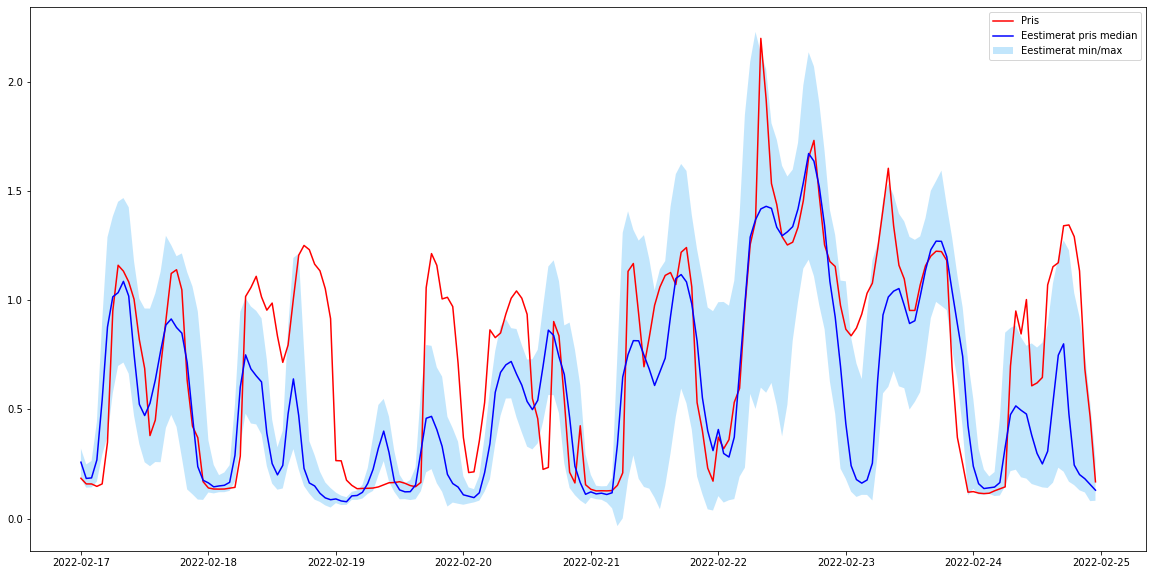

In [39]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))

ax = plt
ax.plot(prediction['SE3'], color='Red', label='Pris')
ax.plot(prediction['0.5'], color='Blue', label='Eestimerat pris median')
ax.fill_between(x = prediction.index,
                y1 = prediction['0.1'],
                y2 = prediction['0.9'],
                facecolor = 'lightskyblue',
                alpha = 0.5,
                label='Eestimerat min/max')
ax.legend()
ax.show()

### Delete endpoints

In [40]:
predictor.delete_model()
predictor.delete_endpoint()